In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Integrating CPHS Data and Code

## Load Data

In [2]:
import pickle

with open(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data\continuous_full_data_block1.pickle", 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    refs_block1, _, _, _, emgs_block1, _, _, _, _, _, _ = pickle.load(handle)

#with open(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data\continuous_full_data_block2.pickle", 'rb') as handle:
#    #refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
#    refs_block2, _, _, _, emgs_block2, _, _, _, _, _, _ = pickle.load(handle)

In [3]:
keys = ['METACPHS_S106', 'METACPHS_S107', 'METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112', 'METACPHS_S113', 'METACPHS_S114', 'METACPHS_S115', 'METACPHS_S116', 'METACPHS_S117', 'METACPHS_S118', 'METACPHS_S119']
key_to_num = dict()
num_to_key = dict()
for idx, key in enumerate(keys):
    key_to_num[key] = idx
    num_to_key[idx] = key

num_conds = 8
num_channels = 64
num_updates = 19
cphs_starting_update = 10
update_ix = [0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]

In [4]:
print(f"EMG Input shape: {emgs_block1[keys[0]].shape}")
print(f"2D Velocity Label shape: {refs_block1[keys[0]].shape}")

EMG Input shape: (8, 20770, 64)
2D Velocity Label shape: (8, 20770, 2)


In [5]:
print("Condition 1")
F1tens_full = torch.from_numpy(emgs_block1[keys[0]][0, :, :])
PREF1tens_full = torch.from_numpy(refs_block1[keys[0]][0, :, :])

Condition 1


In [6]:
num_input_channels = 64  # Change once I add PCA
input_size = num_input_channels
# ^ IRL I'm not sure we are guaranteed to get equalength trials
#  Thus may be better to do every time point individually? Not sure
output_size = 2  # 2D Velocity

learning_rate = 0.00001

# Other option which should give same result:
model = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
print(f"Shape of linear model weights: {model.weight.shape}")

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Shape of linear model weights: torch.Size([2, 64])


## PyTorch Linear Regression With Streamed Data

In [7]:
# TENSOR-IFY THIS FUNCTION!!!
def cost_l2_torch(F, D, V, learning_batch, lambdaF=1e-7, lambdaD=1e-3, lambdaE=1e-6, Nd=2, Ne=64):
    # c_L2 = (lambdaE||DF + V+||_2)^2 + lambdaD*(||D||_2)^2 + lambdaF*(||F||_2)^2
    
    '''
    F: 64 channels x time EMG signals
    V: 2 x time target velocity
    D: 2 (x y vel) x 64 channels decoder
    H: 2 x 2 state transition matrix
    alphaE is 1e-6 for all conditions
    ''' 
    
    # Hmm should I detach and use numpy or just stick with tensor ops?
    # I don't want gradient to be tracked here but idk if it matters...

    Nt = learning_batch
    D = D.view(Nd, Ne)  #np.reshape(D,(Nd,Ne))
    Vplus = V[:,1:]
    # Performance
    term1 = lambdaE*(torch.linalg.matrix_norm((torch.matmul(D, F) - Vplus))**2)
    # D Norm
    term2 = lambdaD*(torch.linalg.matrix_norm((D)**2))
    # F Norm
    term3 = lambdaF*(torch.linalg.matrix_norm((F)**2))
    return (term1 + term2 + term3)

In [8]:
s_temp = torch.tensor(emgs_block1[keys[0]][0], dtype=torch.float32)
# First, normalize the entire s matrix
s_normed = s_temp
#s_normed = s_temp/np.amax(s_temp)

#if self.PCA_comps!=self.pca_channel_default:  
#    pca = PCA(n_components=self.PCA_comps)
#    s_normed = pca.fit_transform(s_normed)
s = np.transpose(s_normed)
#s = s_normed
emg_streamed_batch = s[:,:-1] # F
v_actual =  torch.matmul(model.weight, s)
p_actual = torch.cumsum(v_actual, dim=1)/60  # Numerical integration of v_actual to get p_actual
p_reference = torch.transpose(torch.tensor(refs_block1[keys[0]][0], dtype=torch.float32), 0, 1)
V = (p_reference - p_actual)/60

y = p_reference[:, :-1]  # To match the input

In [9]:
print(f"s.size:                   {s.size()}")
print(f"emg_streamed_batch.size:  {emg_streamed_batch.size()}")
print(f"v_actual.size:            {v_actual.size()}")
print(f"p_actual.size:            {p_actual.size()}")
print(f"p_reference.size:         {p_reference.size()}")
print(f"V.size:                   {V.size()}")
print(f"y.size:                   {y.size()}")

s.size:                   torch.Size([64, 20770])
emg_streamed_batch.size:  torch.Size([64, 20769])
v_actual.size:            torch.Size([2, 20770])
p_actual.size:            torch.Size([2, 20770])
p_reference.size:         torch.Size([2, 20770])
V.size:                   torch.Size([2, 20770])
y.size:                   torch.Size([2, 20769])


In [10]:
# I think this is implicitly SGD?
'''
num_epochs = 100
loss_log = []
for my_epoch in range(num_epochs):
    # forward pass and loss
    y_pred = model(emg_streamed_batch)
    # F, D, V, learning_batch
    loss = cost_l2_torch(emg_streamed_batch, model.weight, V, emg_streamed_batch.shape[0])
    # backward pass
    loss.backward()
    loss_log.append(loss.item())
    # update weights
    optimizer.step()
    # reset gradient so it doesn't accumulate
    optimizer.zero_grad()
    
    if (my_epoch+1)%10==0:
        print(f"Epoch: {my_epoch+1}, loss: {loss.item():.4f}")
'''

# This is without SGD
loss_log = []
# reset gradient so it doesn't accumulate
optimizer.zero_grad()
# forward pass and loss
y_pred = model(torch.transpose(emg_streamed_batch, 0, 1))
# F, D, V, learning_batch
#loss = cost_l2_torch(emg_streamed_batch, model.weight, V, emg_streamed_batch.shape[0])
loss = criterion(y_pred, torch.transpose(y, 0, 1))
# backward pass
loss.backward(retain_graph=True)
loss_log.append(loss.item())
# update weights
optimizer.step()


In [11]:
loss_log

[389.7366638183594]

In [12]:
for _ in range(20):
    # forward pass and loss
    y_pred = model(torch.transpose(emg_streamed_batch, 0, 1))
    # F, D, V, learning_batch
    loss = cost_l2_torch(emg_streamed_batch, model.weight, V, emg_streamed_batch.shape[0])
    # backward pass
    loss.backward(retain_graph=True)
    loss_log.append(loss.item())
    # update weights
    optimizer.step()
    # reset gradient so it doesn't accumulate
    optimizer.zero_grad()

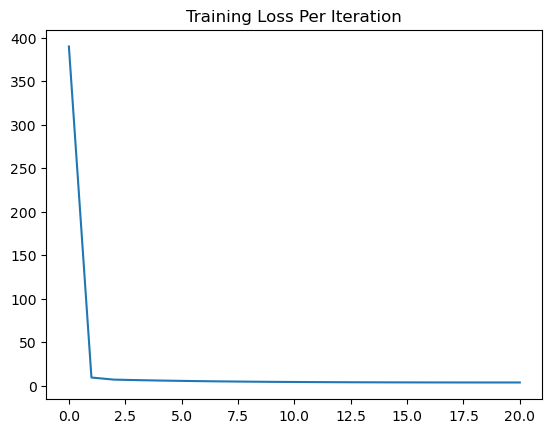

In [13]:
plt.plot(range(len(loss_log)), loss_log)
plt.title("Training Loss Per Iteration")
plt.show()

In [15]:
print(f"Final Loss: {loss_log[-1]}")
print("----- ----- ----- ----- -----")
print("Prediction:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
        print(param.shape)
        print(param.data)
        print()

Final Loss: 3.547281265258789
----- ----- ----- ----- -----
Prediction:
weight
torch.Size([2, 64])
tensor([[ 0.0071, -0.0782, -0.0301, -0.1003,  0.0489,  0.0886, -0.0993, -0.1256,
          0.0548,  0.0460, -0.0231, -0.0860,  0.0059,  0.0601,  0.0322, -0.0528,
          0.0283, -0.0355,  0.0994, -0.1262, -0.0036,  0.0144,  0.0440, -0.1220,
          0.0742, -0.0356, -0.0914, -0.0166,  0.0517,  0.0301, -0.1092,  0.0802,
         -0.1256, -0.0552,  0.0481,  0.1079, -0.0866,  0.1107, -0.1059,  0.0643,
         -0.0391,  0.0065,  0.0860, -0.0419, -0.0227,  0.0707,  0.0177,  0.0236,
          0.0257,  0.0628, -0.0245, -0.0977,  0.0489, -0.0370,  0.0780,  0.0706,
          0.1011, -0.0394,  0.0197, -0.0712,  0.0596, -0.0798,  0.0258, -0.0994],
        [ 0.1083, -0.0759, -0.0734, -0.0190,  0.0708, -0.0247, -0.0164, -0.1121,
          0.0650,  0.0810, -0.1092, -0.0432,  0.0771,  0.0228, -0.0680,  0.0002,
          0.1034,  0.0141,  0.0680,  0.0365, -0.0089,  0.0968, -0.0879,  0.0099,
         

# Validation with SKLearn
> Note that using Least Squares, we can solve for the closed-form solution (e.g. don't need to iteratively solve via gradient descent).  However, for the federated case, we can't just use the one-shot closed-form solution since averaging local solutions can perform arbitrarily poorly (...); likewise, each client does not have the full dataset (e.g. all the data in the network) and thus will not solve for the overall solution (only their local solution, which as discussed above, is a poor global solution).

In [16]:
import sklearn.linear_model
linr = sklearn.linear_model.LinearRegression()
linr.fit(torch.transpose(emg_streamed_batch,0,1), torch.transpose(y,0,1))

LinearRegression()

In [17]:
x_segment = torch.transpose(emg_streamed_batch,0,1)#[0:10, :]
y_segment = torch.transpose(y,0,1)#[0:10, :]

print(f"Score Loss: {linr.score(x_segment, y_segment)}")
print(f"Criterion Loss: {criterion(torch.tensor(linr.predict(x_segment)), y_segment)}")
print("---------------------------------------------")
print("Prediction:")
print(f"b_pred = {linr.intercept_.shape}")
print(linr.intercept_)
print()
print(f"w_pred = {linr.coef_.shape}")
print(linr.coef_)

Score Loss: 0.06864621346144306
Criterion Loss: 333.3614807128906
---------------------------------------------
Prediction:
b_pred = (2,)
[ 0.46993703 -0.0385526 ]

w_pred = (2, 64)
[[ 2.40124483e-02 -9.36831385e-02  1.53238133e-01 -2.23963380e-01
  -1.79743603e-01 -1.52014822e-01  2.40779668e-01  3.73023778e-01
   6.10416055e-01 -5.79407990e-01  9.19592939e-03  1.05793029e-01
  -2.82876372e-01  2.14374751e-01  8.16345364e-02 -5.95871434e-02
  -3.16082209e-01 -2.66652666e-02 -4.11208197e-02 -1.66244283e-02
  -1.83624029e-03  1.98739648e-01  5.33615574e-02  1.72303990e-01
  -1.19486839e-01 -1.52319809e-02 -7.01479763e-02 -3.99511755e-01
   1.07548825e-01 -4.21305507e-01  2.95056522e-01 -4.54902083e-01
  -3.40486497e-01  2.85937697e-01  1.11674048e-01 -4.24735904e-01
   4.20217931e-01 -3.73527288e-01 -2.73745775e-01  2.68808544e-01
   2.14586690e-01 -4.32256341e-01 -4.97918457e-01  1.61880925e-02
   1.24138124e-01 -3.05034369e-02  2.83400714e-01  2.15865955e-01
   6.93321377e-02 -5.48151

In [ ]:
# I don't really see the value in testing the same model at every training pair...
